In [1]:
!unzip /content/Dataset_Final.zip -d /content/Dataset_Final

Archive:  /content/Dataset_Final.zip
   creating: /content/Dataset_Final/Dataset_Final/
   creating: /content/Dataset_Final/Dataset_Final/Fashion/
   creating: /content/Dataset_Final/Dataset_Final/Fashion/test/
  inflating: /content/Dataset_Final/Dataset_Final/Fashion/test/Defect_1.jpg  
  inflating: /content/Dataset_Final/Dataset_Final/Fashion/test/Defect_10.jpg  
  inflating: /content/Dataset_Final/Dataset_Final/Fashion/test/Defect_11.jpg  
  inflating: /content/Dataset_Final/Dataset_Final/Fashion/test/Defect_12.jpg  
  inflating: /content/Dataset_Final/Dataset_Final/Fashion/test/Defect_13.jpg  
  inflating: /content/Dataset_Final/Dataset_Final/Fashion/test/Defect_14.jpg  
  inflating: /content/Dataset_Final/Dataset_Final/Fashion/test/Defect_15.jpg  
  inflating: /content/Dataset_Final/Dataset_Final/Fashion/test/Defect_16.jpg  
  inflating: /content/Dataset_Final/Dataset_Final/Fashion/test/Defect_17.jpg  
  inflating: /content/Dataset_Final/Dataset_Final/Fashion/test/Defect_18.jpg  


In [33]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
from tqdm import tqdm

In [34]:
class CAETrainDataset(Dataset):
    def __init__(self, folder, transform=None):
        self.paths = [
            os.path.join(folder, f)
            for f in os.listdir(folder)
            if f.lower().endswith((".jpg", ".png", ".jpeg"))
        ]
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img


In [ ]:
class CAETestDataset(Dataset):
    def __init__(self, folder, transform=None):
        self.paths = []
        self.labels = []
        self.transform = transform

        for f in os.listdir(folder):
            if not f.lower().endswith((".jpg", ".png", ".jpeg")):
                continue

            self.paths.append(os.path.join(folder, f))

            if "defect" in f.lower():
                self.labels.append(1)  
            else:
                self.labels.append(0)  

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, self.labels[idx]


In [36]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [37]:
BASE_PATH = "/content/Dataset_Final/Dataset_Final/Fashion"

train_loader = DataLoader(
    CAETrainDataset(os.path.join(BASE_PATH, "train"), transform),
    batch_size=16, shuffle=True
)

val_loader = DataLoader(
    CAETrainDataset(os.path.join(BASE_PATH, "valid"), transform),
    batch_size=16, shuffle=False
)

test_loader = DataLoader(
    CAETestDataset(os.path.join(BASE_PATH, "test"), transform),
    batch_size=1, shuffle=False
)

In [ ]:
class CAE(nn.Module):
    def __init__(self):
        super(CAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 16, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2)
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = CAE().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 15
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0

    for imgs in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        imgs = imgs.to(device)

        optimizer.zero_grad()
        recon = model(imgs)
        loss = criterion(recon, imgs)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

    train_loss = running_train_loss / len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    running_val_loss = 0
    with torch.no_grad():
        for imgs in val_loader:
            imgs = imgs.to(device)
            recon = model(imgs)
            loss = criterion(recon, imgs)
            running_val_loss += loss.item()

    val_loss = running_val_loss / len(val_loader)
    val_losses.append(val_loss)

    print(f"Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")

Epoch 1/15: 100%|██████████| 69/69 [00:52<00:00,  1.32it/s]


Train Loss: 0.049427 | Val Loss: 0.028730


Epoch 2/15: 100%|██████████| 69/69 [00:50<00:00,  1.36it/s]


Train Loss: 0.024968 | Val Loss: 0.020607


Epoch 3/15: 100%|██████████| 69/69 [00:50<00:00,  1.36it/s]


Train Loss: 0.009236 | Val Loss: 0.006109


Epoch 4/15: 100%|██████████| 69/69 [00:51<00:00,  1.34it/s]


Train Loss: 0.006148 | Val Loss: 0.005017


Epoch 5/15: 100%|██████████| 69/69 [00:51<00:00,  1.35it/s]


Train Loss: 0.005709 | Val Loss: 0.004698


Epoch 6/15: 100%|██████████| 69/69 [00:48<00:00,  1.41it/s]


Train Loss: 0.005219 | Val Loss: 0.004248


Epoch 7/15: 100%|██████████| 69/69 [00:51<00:00,  1.35it/s]


Train Loss: 0.004346 | Val Loss: 0.003708


Epoch 8/15: 100%|██████████| 69/69 [00:50<00:00,  1.37it/s]


Train Loss: 0.003738 | Val Loss: 0.003263


Epoch 9/15: 100%|██████████| 69/69 [00:51<00:00,  1.34it/s]


Train Loss: 0.003376 | Val Loss: 0.003115


Epoch 10/15: 100%|██████████| 69/69 [00:51<00:00,  1.33it/s]


Train Loss: 0.003524 | Val Loss: 0.004404


Epoch 11/15: 100%|██████████| 69/69 [00:50<00:00,  1.35it/s]


Train Loss: 0.003159 | Val Loss: 0.003100


Epoch 12/15: 100%|██████████| 69/69 [00:50<00:00,  1.36it/s]


Train Loss: 0.003128 | Val Loss: 0.003252


Epoch 13/15: 100%|██████████| 69/69 [00:51<00:00,  1.35it/s]


Train Loss: 0.002794 | Val Loss: 0.004124


Epoch 14/15: 100%|██████████| 69/69 [00:51<00:00,  1.35it/s]


Train Loss: 0.004434 | Val Loss: 0.003341


Epoch 15/15: 100%|██████████| 69/69 [00:53<00:00,  1.30it/s]


Train Loss: 0.003105 | Val Loss: 0.003032


In [40]:
model.eval()
scores = []
labels = []

with torch.no_grad():
    for img, label in test_loader:
        img = img.to(device)
        recon = model(img)

        error = torch.mean((img - recon) ** 2).item()
        scores.append(error)
        labels.append(label)

In [ ]:
val_scores = []

model.eval()
with torch.no_grad():
    for imgs in val_loader:
        imgs = imgs.to(device)
        recon = model(imgs)
        errors = torch.mean((imgs - recon) ** 2, dim=[1,2,3])
        val_scores.extend(errors.cpu().numpy())

threshold = np.percentile(val_scores, 99)
print("Anomaly threshold:", threshold)

Anomaly threshold: 0.013666835


In [42]:
import matplotlib.pyplot as plt

def predict_and_display(image_path, model, transform, threshold):
    model.eval()

    img = Image.open(image_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        recon = model(img_tensor)
        error_map = (img_tensor - recon).pow(2).mean(dim=1).squeeze().cpu().numpy()
        score = error_map.mean()

    prediction = "DEFECT" if score > threshold else "NORMAL"
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    axs[0].imshow(img)
    axs[0].set_title("Original")
    axs[0].axis("off")

    axs[1].imshow(recon.squeeze().permute(1,2,0).cpu())
    axs[1].set_title("Reconstruction")
    axs[1].axis("off")

    axs[2].imshow(error_map, cmap="hot")
    axs[2].set_title(f"Error Map\nScore: {score:.6f}\nPred: {prediction}")
    axs[2].axis("off")

    plt.show()

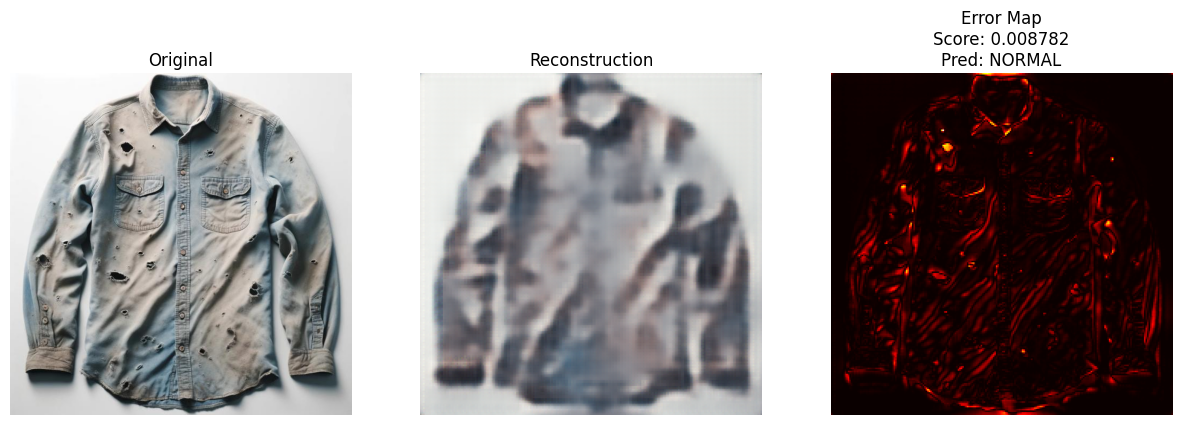

In [43]:
predict_and_display(
    "/content/Dataset_Final/Dataset_Final/Fashion/test/Defect_1.jpg",
    model,
    transform,
    threshold
)


In [44]:
def show_test_predictions(model, test_loader, threshold, num_images=5):
    model.eval()
    count = 0

    with torch.no_grad():
        for img, label in test_loader:
            img = img.to(device)
            recon = model(img)

            error_map = (img - recon).pow(2).mean(dim=1).squeeze().cpu().numpy()
            score = error_map.mean()
            pred = "DEFECT" if score > threshold else "NORMAL"
            gt = "DEFECT" if label.item() == 1 else "NORMAL"

            fig, axs = plt.subplots(1, 3, figsize=(15, 5))

            axs[0].imshow(img.squeeze().permute(1,2,0).cpu())
            axs[0].set_title(f"Original (GT: {gt})")
            axs[0].axis("off")

            axs[1].imshow(recon.squeeze().permute(1,2,0).cpu())
            axs[1].set_title("Reconstruction")
            axs[1].axis("off")

            axs[2].imshow(error_map, cmap="hot")
            axs[2].set_title(f"Pred: {pred}\nScore: {score:.6f}")
            axs[2].axis("off")

            plt.show()

            count += 1
            if count >= num_images:
                break


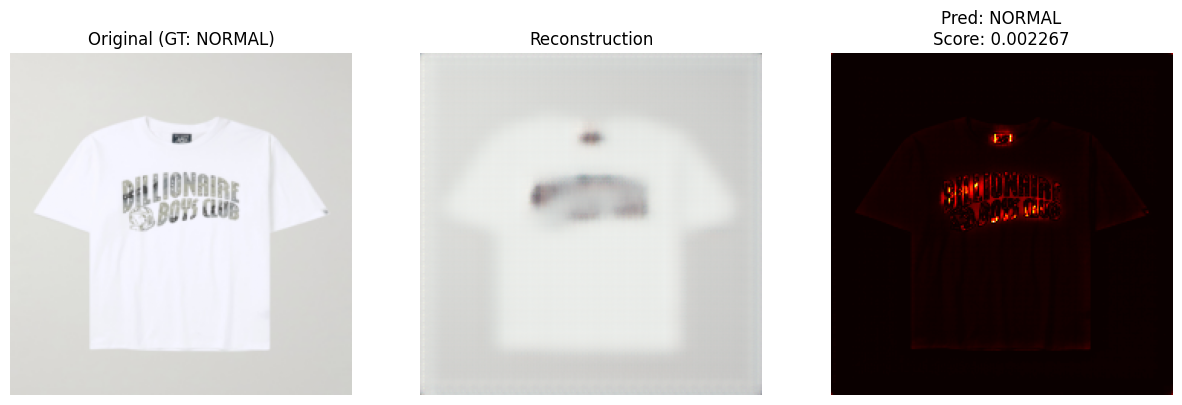

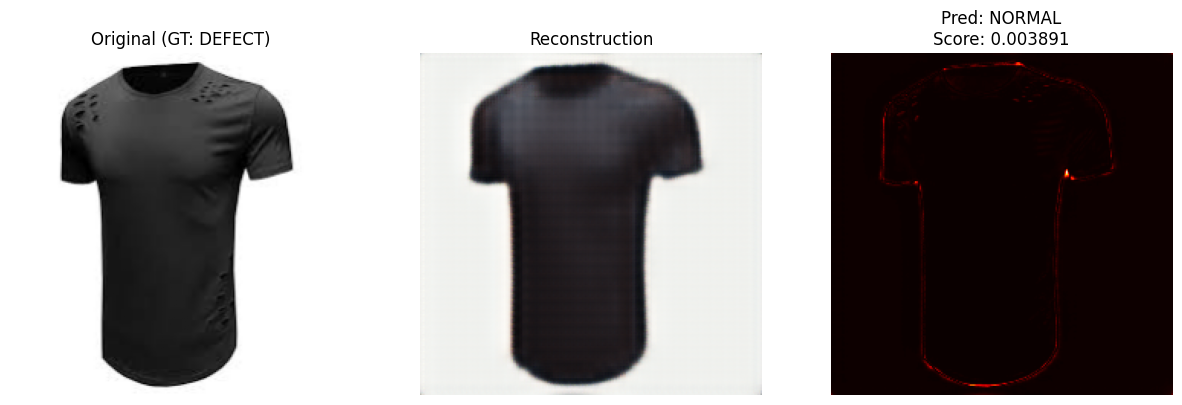

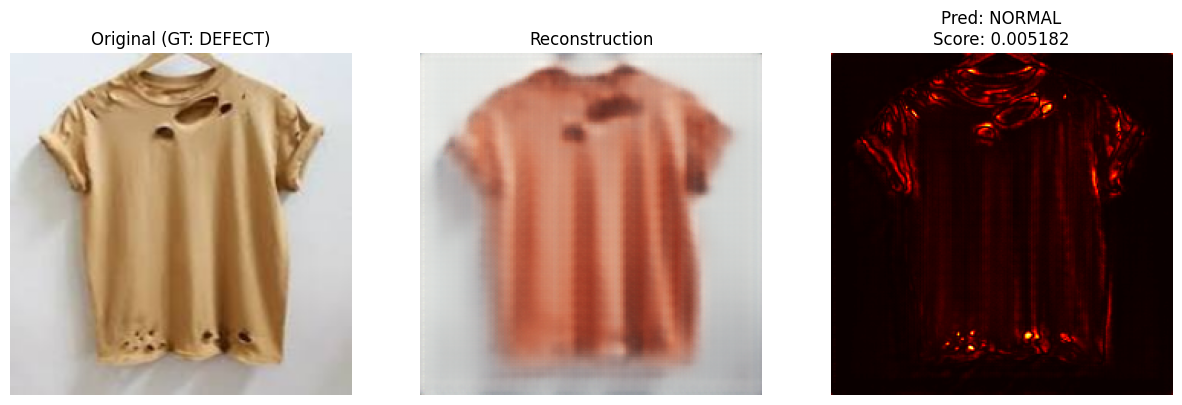

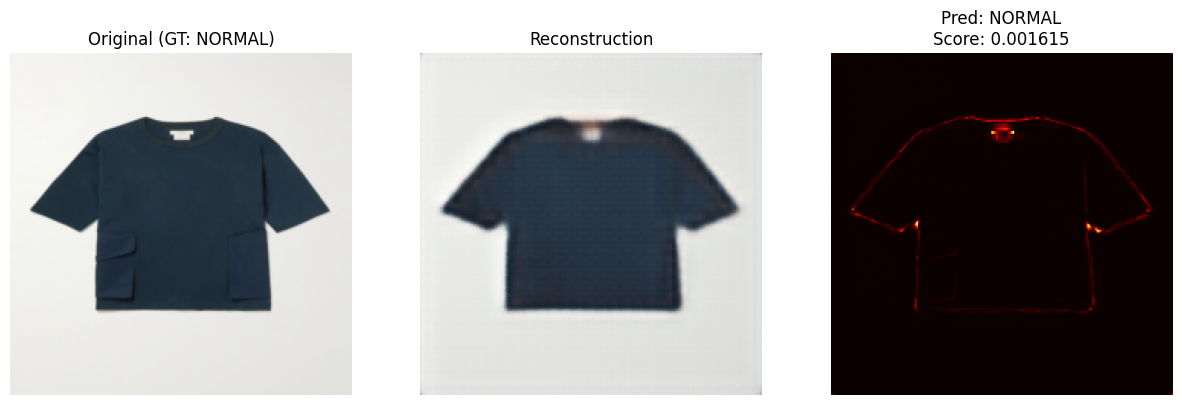

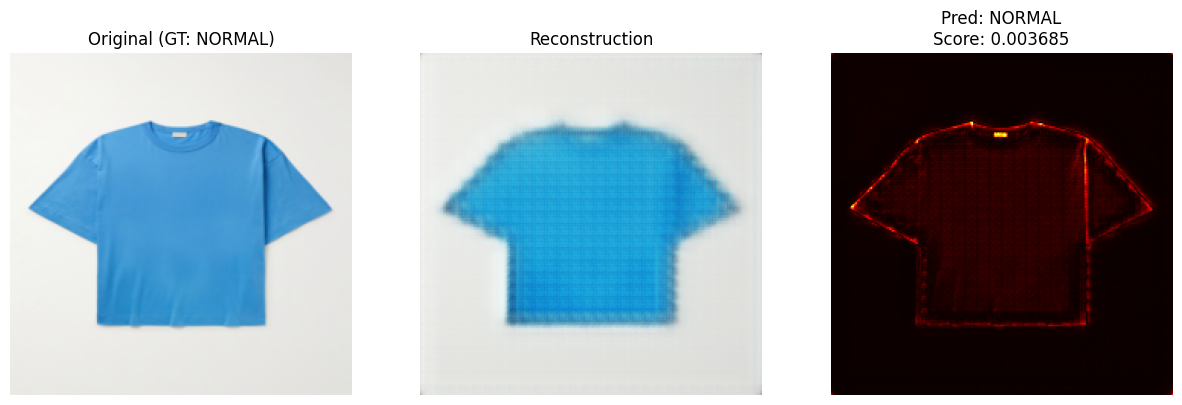

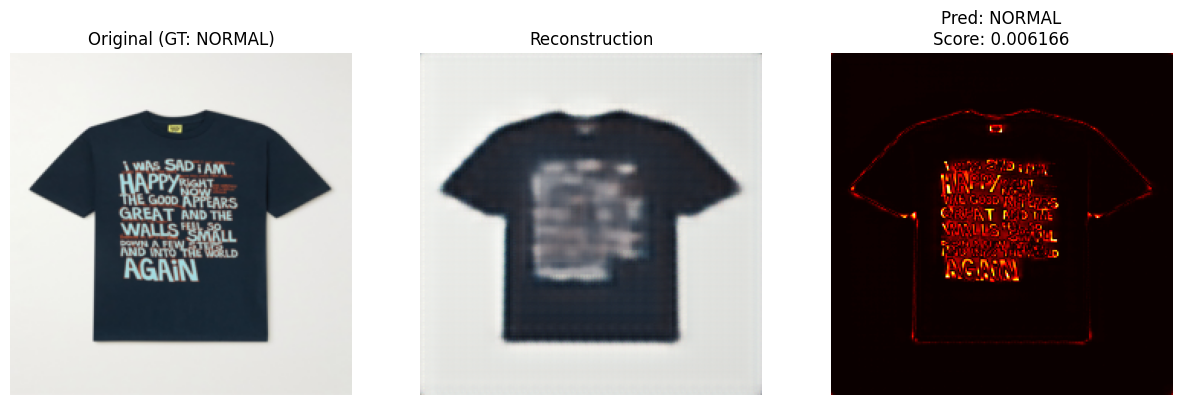

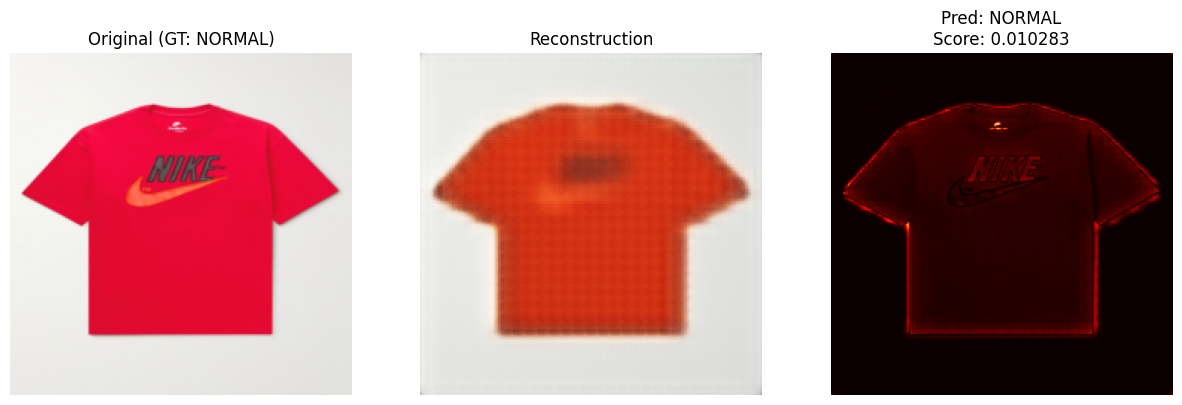

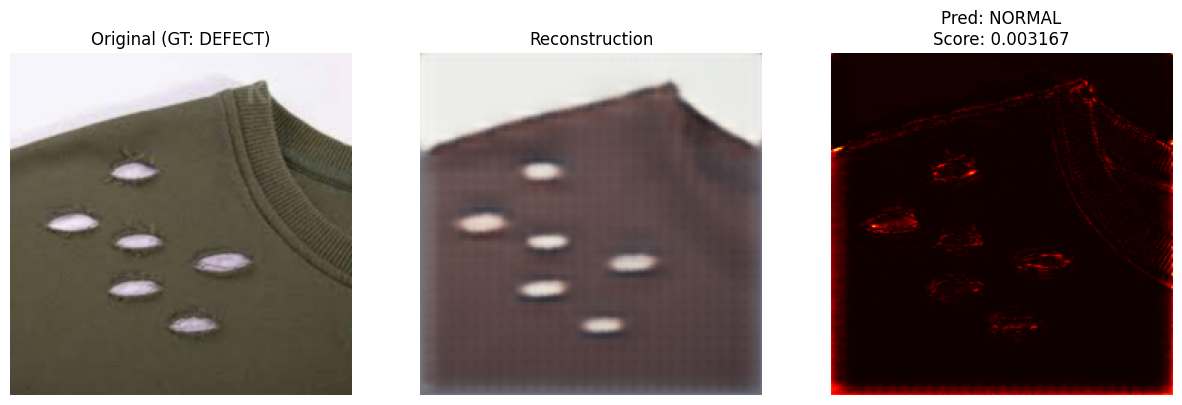

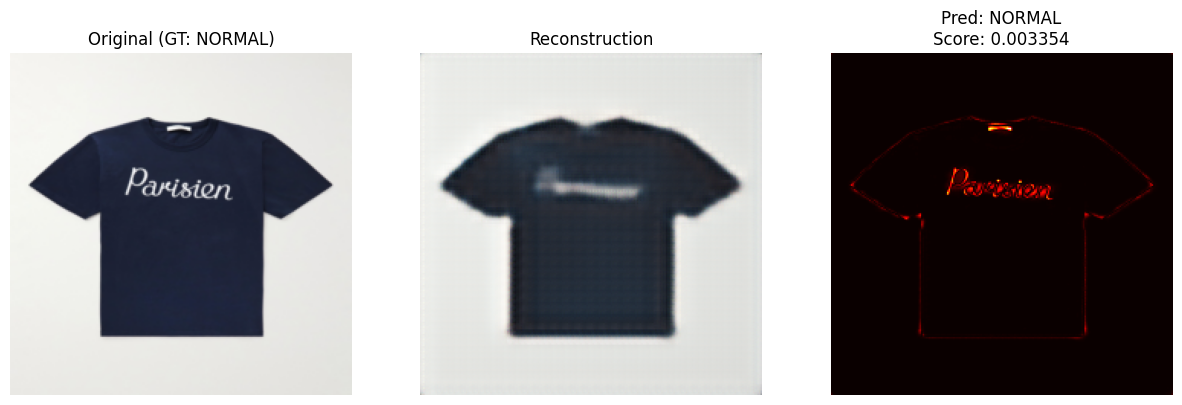

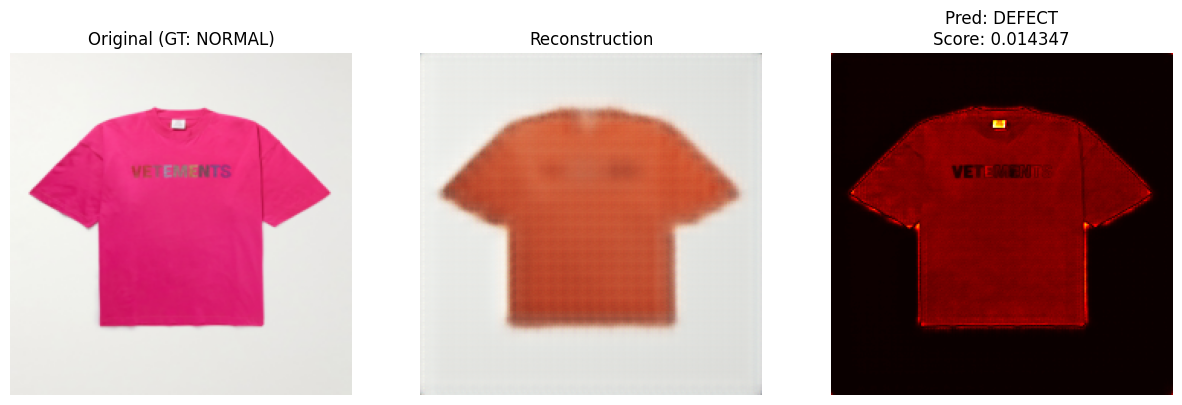

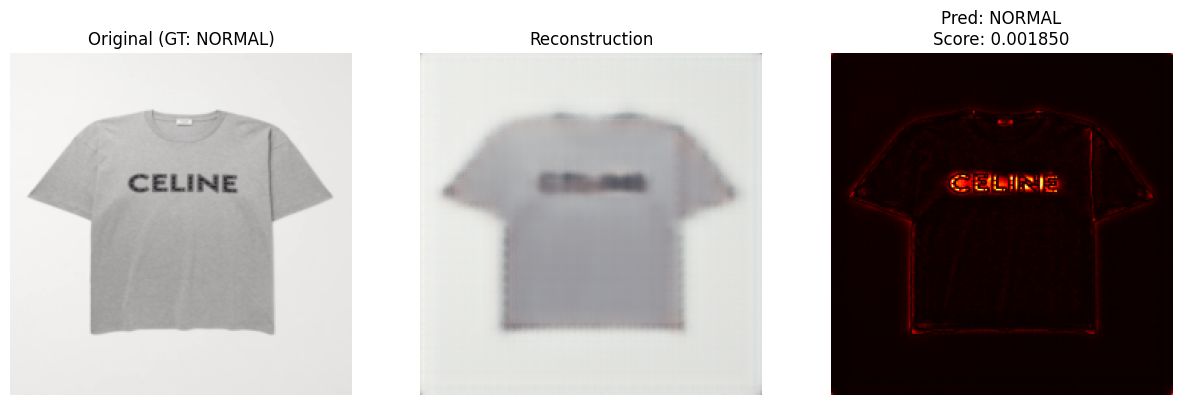

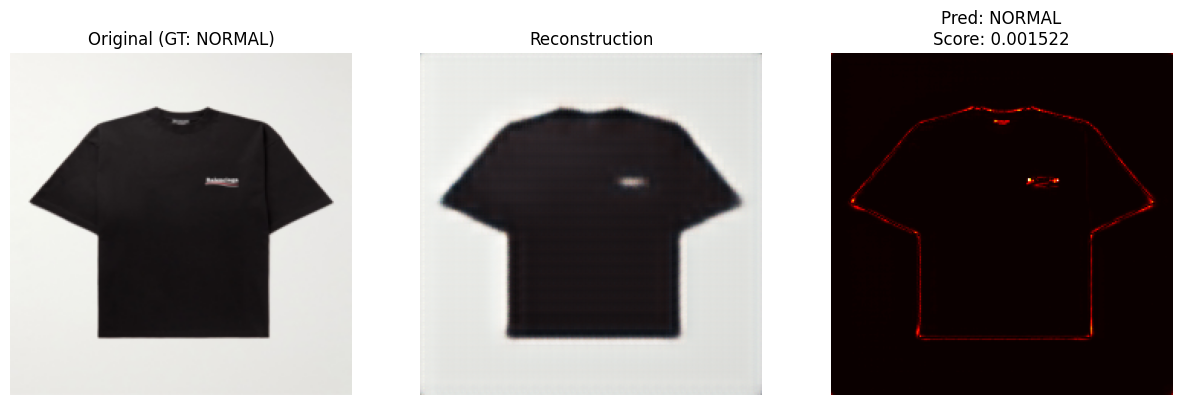

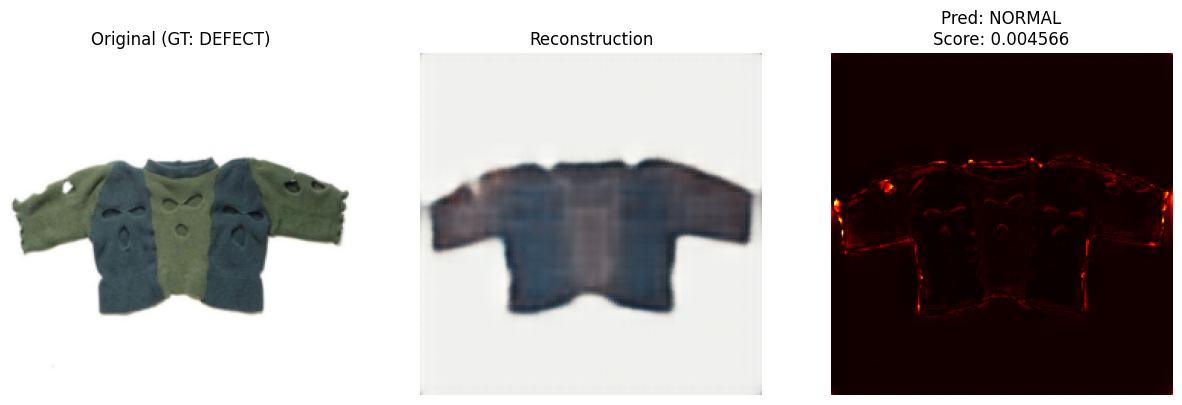

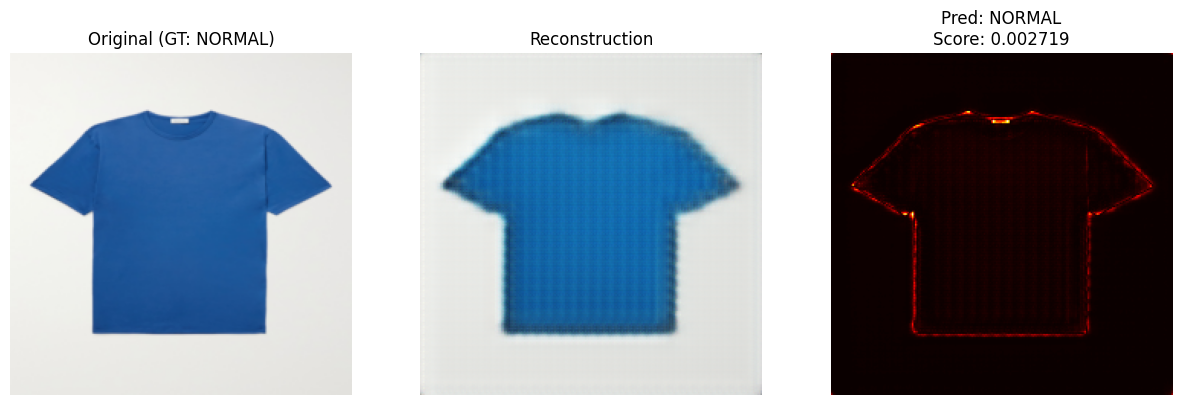

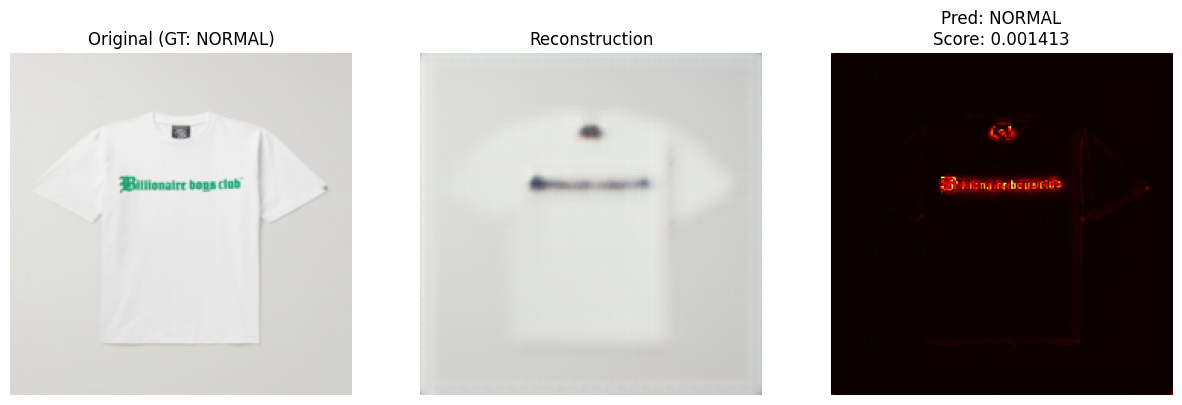

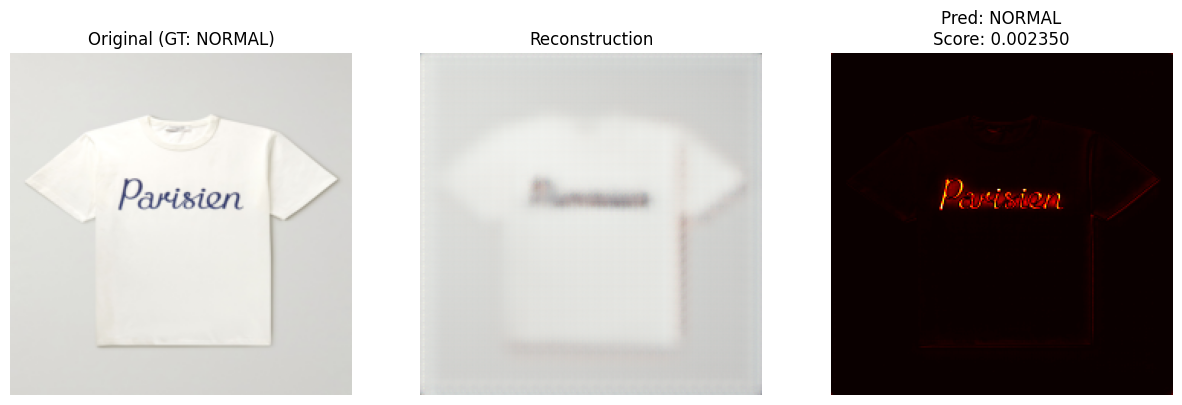

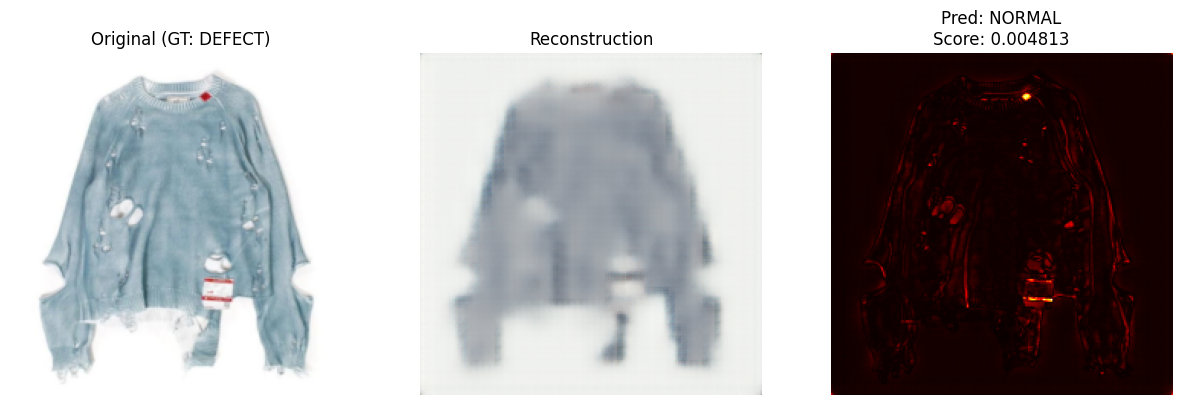

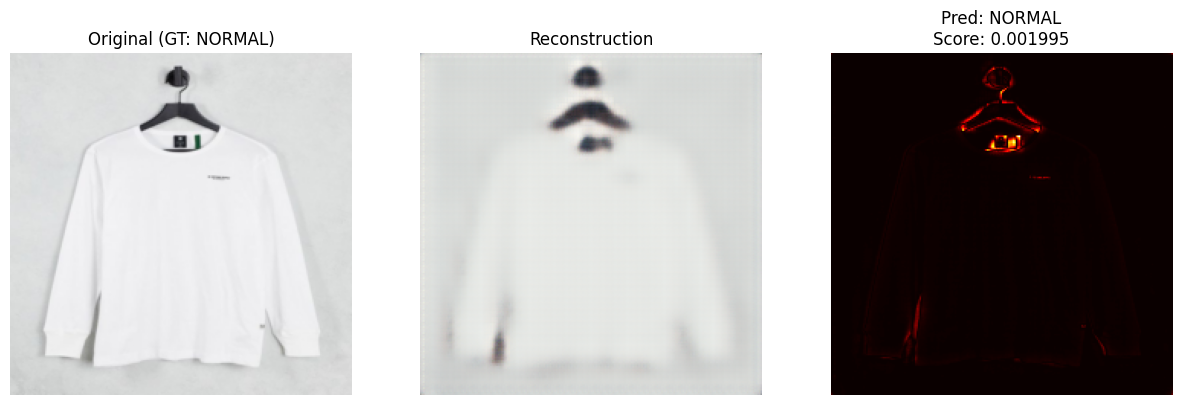

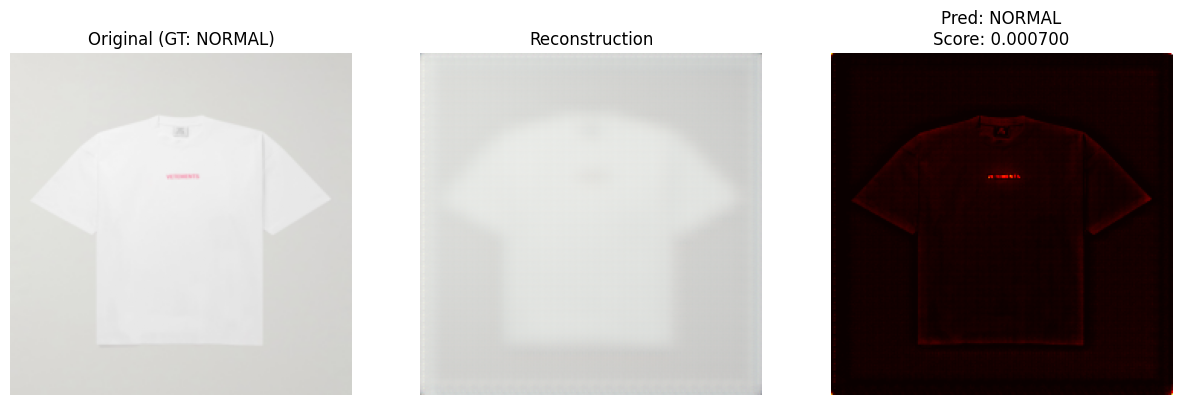

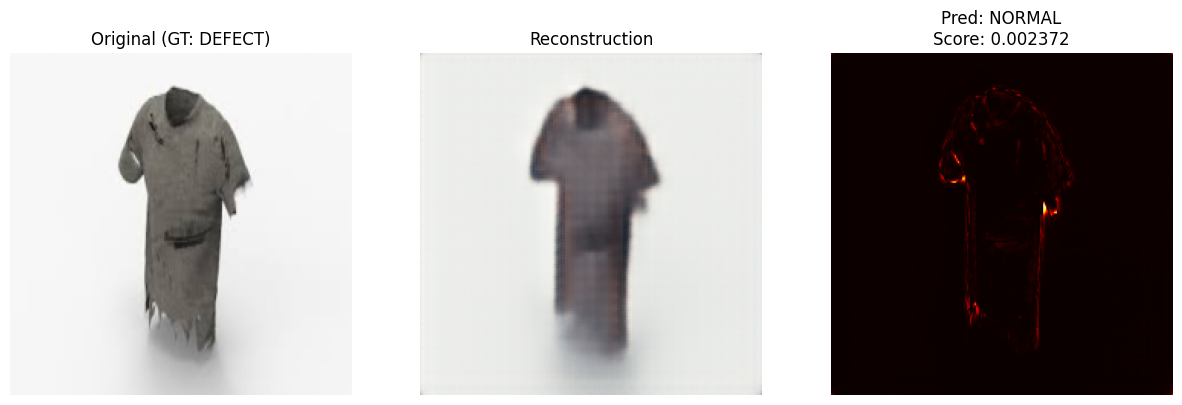

In [45]:
show_test_predictions(model, test_loader, threshold, num_images=20)

ROC-AUC: 0.888681592039801


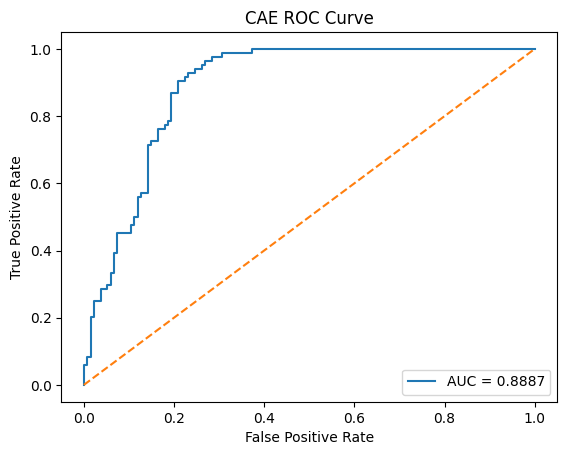

In [19]:
auc = roc_auc_score(labels, scores)
print("ROC-AUC:", auc)

fpr, tpr, _ = roc_curve(labels, scores)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], "--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("CAE ROC Curve")
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        recon = model(imgs)

        errors = ((imgs - recon) ** 2).mean(dim=(1,2,3)).cpu().numpy()

        preds = (errors > threshold).astype(int)

        y_true.extend(labels.numpy())
        y_pred.extend(preds)

accuracy  = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, zero_division=0)
recall    = recall_score(y_true, y_pred, zero_division=0)
f1        = f1_score(y_true, y_pred, zero_division=0)

print("CAE Metrics")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-score : {f1:.4f}")

CAE Metrics
Accuracy : 0.6193
Precision: 0.6000
Recall   : 0.0357
F1-score : 0.0674


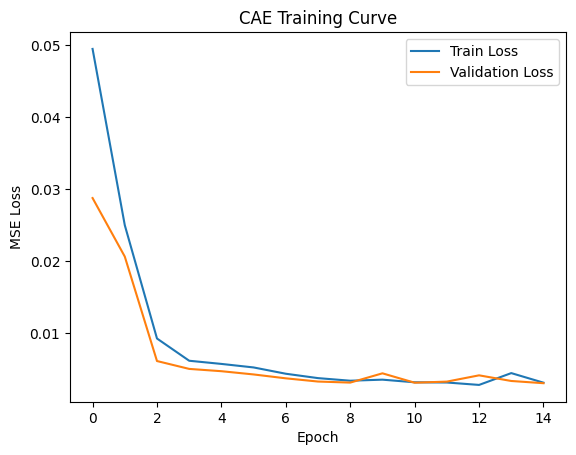

In [49]:
plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("CAE Training Curve")
plt.legend()
plt.show()

In [54]:
torch.save(model.state_dict(), "cae_best_model.pth")
np.save("cae_threshold.npy", threshold)

In [55]:
!zip cae_saved.zip cae_best_model.pth cae_threshold.npy

  adding: cae_best_model.pth (deflated 8%)
  adding: cae_threshold.npy (deflated 47%)
